## TCC - PUC MINAS
## Pó-graduação Lato Sensu em Ciência de Dados e Big Data

#`Aluno: Cássio Correia dos Santos`
#`Ano: 2021`
#`Tema: Predição de vendas e a satisfação dos clientes em Marketplace`

In [18]:
pip install pmdarima   # instação do pacote ARIMA

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1 - Importação das bibliotecas

In [20]:
# Geral
import math
import pandas as pd


# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# ML
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

# Visualização
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# import math




##2 - Leitura dos arquivos
arquivos coletados do Kaggle
https://www.kaggle.com/olistbr/brazilian-ecommerce


In [21]:
dfCustomers = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TCC/dataset/olist_customers_dataset.csv")
dfOrder = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TCC/dataset/olist_orders_dataset.csv")
dfOrder_items = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TCC/dataset/olist_order_items_dataset.csv")
dfProducts = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TCC/dataset/olist_products_dataset.csv")
dfOrder_review = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TCC/dataset/olist_order_reviews_dataset.csv")

##3 - Processamento / Tratamento de Dados

In [22]:
# visualizando os registros de pedidos, os 5 primeiros registros
dfOrder.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [23]:
dfOrder.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [24]:
dfOrder.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Transformando coluna de data em tipo datetime

In [25]:
dfOrder["order_purchase_timestamp"] = pd.to_datetime(dfOrder["order_purchase_timestamp"], errors='coerce')

criando novas colunas no dataset Pedidos com formato AAAA-MM, AAAA-MM-DD sem a hora para posterior agrupamento das informações 

In [26]:
dfOrder["Ano_Mes_venda"] = dfOrder["order_purchase_timestamp"].dt.strftime('%Y-%m')
dfOrder["Ano_Mes_Dia_venda"] = dfOrder["order_purchase_timestamp"].dt.strftime('%Y-%m-%d')

dfOrder["Ano_Compra"] = dfOrder["order_purchase_timestamp"].dt.year


In [27]:
dfOrder.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
Ano_Mes_venda                            object
Ano_Mes_Dia_venda                        object
Ano_Compra                                int64
dtype: object

agrupamento de pedidos e contagem de pedidos dia
em seguida a estatísticas do dataset de pedidos dia
média de 160 pedidos dia

In [28]:
pedidos_dia = dfOrder[dfOrder['order_status']!='canceled'].groupby("Ano_Mes_Dia_venda")["order_id"].count().reset_index()
pedidos_dia.describe()

,order_id
count,614.000000
mean,160.938111
std,91.136075
min,1.000000
25%,99.000000
50%,149.000000
75%,216.750000
max,1176.000000


{'boxes': [<matplotlib.lines.Line2D at 0x7fe0fff88e90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe0fff51810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe101c68310>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe101cacdd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe0fffb9f90>,
  <matplotlib.lines.Line2D at 0x7fe0fff51590>]}

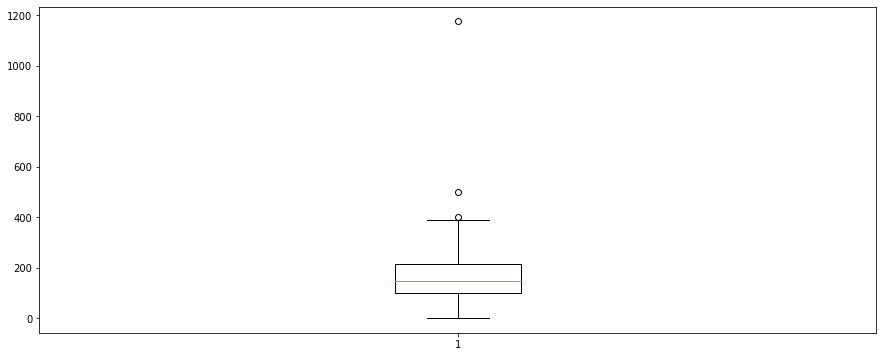

In [29]:
import matplotlib.pyplot as plt
plt.boxplot(pedidos_dia["order_id"])

Identificando o Outlier, dias 24, 25 e 27 de Novembro de 2017 quando tiver a Black Friday

In [30]:
pedidos_dia[pedidos_dia["order_id"] > 400]

,Ano_Mes_Dia_venda,order_id
334,2017-11-24,1176
335,2017-11-25,499
337,2017-11-27,403


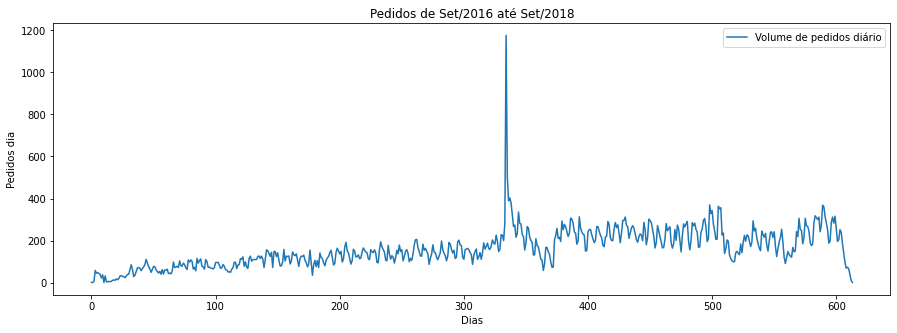

In [31]:
plt.figure(figsize=(15,5))
plt.plot(pedidos_dia['order_id'], label='Volume de pedidos diário')
plt.xlabel('Dias')
plt.ylabel('Pedidos dia')
plt.title('Pedidos de Set/2016 até Set/2018')
plt.legend()
plt.show()

Volume de vendas mês, média de 4 mil pedidos mês

In [32]:
pedidos_mes = dfOrder[dfOrder['order_status']!='canceled'].groupby("Ano_Mes_venda")["order_id"].count().reset_index()
pedidos_mes.head(15)

,Ano_Mes_venda,order_id
0,2016-09,2
1,2016-10,300
2,2016-12,1
3,2017-01,797
4,2017-02,1763
5,2017-03,2649
6,2017-04,2386
7,2017-05,3671
8,2017-06,3229
9,2017-07,3998


In [33]:
pedidos_mes.describe()

,order_id
count,24.000000
mean,4117.333333
std,2614.501809
min,1.000000
25%,2230.250000
50%,4284.500000
75%,6484.750000
max,7507.000000


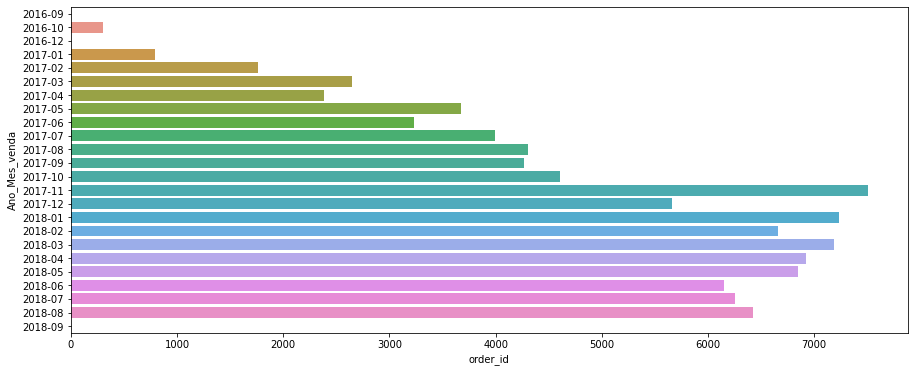

In [34]:
sns.barplot(y='Ano_Mes_venda',x='order_id', data=pedidos_mes,  ) 

In [35]:
# quais os status existentes
dfOrder["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Verificando onde tem dados faltantes

In [36]:
dfOrder.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
Ano_Mes_venda                       0
Ano_Mes_Dia_venda                   0
Ano_Compra                          0
dtype: int64

Estrutura do dataset de clientes

In [37]:
dfCustomers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [38]:
dfCustomers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [39]:
#quantidade de pedidos por Status
dfOrder.groupby("order_status")["order_id"].count()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_id, dtype: int64

**Merge de Pedidos e Clientes**

In [40]:
dfOrderCustomers = pd.merge(dfOrder, dfCustomers, how='inner', on='customer_id')
dfOrderCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
 8   Ano_Mes_venda                  99441 non-null  object        
 9   Ano_Mes_Dia_venda              99441 non-null  object        
 10  Ano_Compra                     99441 non-null  int64         
 11  customer_unique

Estrutura do dataset de itens dos pedidos

In [41]:
# item do pedido 
dfOrder_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [42]:
dfOrder_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Removendo a duplicidade do dataset itens do pedido, passado de 112650 para 102425 registros


In [43]:
# removendo linhas duplicadas do item . Exemplo 
# dfOrder_items[dfOrder_items["order_id"]=="e8fd20068b9f7e6ec07068bb7537f781"]

del dfOrder_items['order_item_id']  
dfOrder_items = dfOrder_items.drop_duplicates()
dfOrder_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             102425 non-null  object 
 1   product_id           102425 non-null  object 
 2   seller_id            102425 non-null  object 
 3   shipping_limit_date  102425 non-null  object 
 4   price                102425 non-null  float64
 5   freight_value        102425 non-null  float64
dtypes: float64(2), object(4)
memory usage: 5.5+ MB


**Merge do Pedido/Cliente com Itens do pedidos**

In [44]:
dfItens = pd.merge(dfOrderCustomers, dfOrder_items, how='inner', on='order_id')
dfItens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 102424
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       102425 non-null  object        
 1   customer_id                    102425 non-null  object        
 2   order_status                   102425 non-null  object        
 3   order_purchase_timestamp       102425 non-null  datetime64[ns]
 4   order_approved_at              102411 non-null  object        
 5   order_delivered_carrier_date   101397 non-null  object        
 6   order_delivered_customer_date  100195 non-null  object        
 7   order_estimated_delivery_date  102425 non-null  object        
 8   Ano_Mes_venda                  102425 non-null  object        
 9   Ano_Mes_Dia_venda              102425 non-null  object        
 10  Ano_Compra                     102425 non-null  int64         
 11  

Estrutura do dataset de Produtos

In [45]:
dfProducts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


**Merge do dataset Itens do Pedido com Produto**

In [46]:
dfVendas_Cliente = pd.merge(dfItens, dfProducts, how='inner', on='product_id')
dfVendas_Cliente.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 102424
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       102425 non-null  object        
 1   customer_id                    102425 non-null  object        
 2   order_status                   102425 non-null  object        
 3   order_purchase_timestamp       102425 non-null  datetime64[ns]
 4   order_approved_at              102411 non-null  object        
 5   order_delivered_carrier_date   101397 non-null  object        
 6   order_delivered_customer_date  100195 non-null  object        
 7   order_estimated_delivery_date  102425 non-null  object        
 8   Ano_Mes_venda                  102425 non-null  object        
 9   Ano_Mes_Dia_venda              102425 non-null  object        
 10  Ano_Compra                     102425 non-null  int64         
 11  

Agrupa para obter a quantidade de pedidos por estado

In [47]:
dfOrderCustomers.groupby("customer_state")["order_id"].count().sort_values(ascending=False)

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: order_id, dtype: int64

In [48]:
dfOrder_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Plotagem dos scores de avaliação da compra

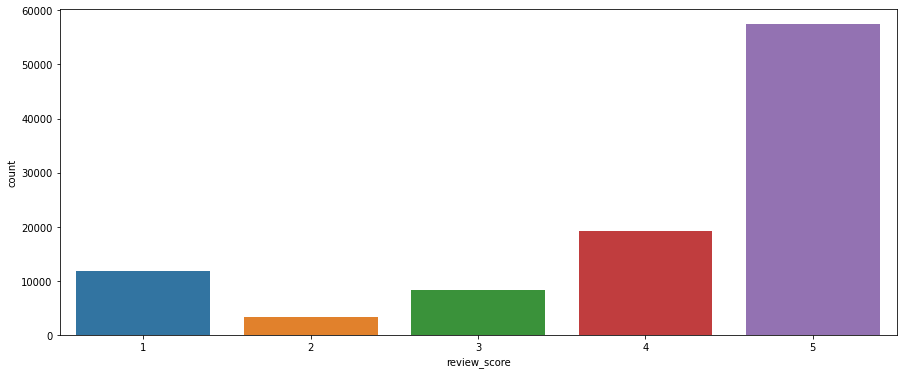

In [49]:
sns.countplot(x='review_score',data=dfOrder_review)

## 5 - Criação do Modelo : Serie temporal

In [50]:
# Com o plot das vendas mês verificou a tendencia de crescimento nas vendas
# foram removidas vendas mês inferior a 5 pedidos 

serie_pedidos_mes = dfVendas_Cliente[dfVendas_Cliente['Ano_Compra']!=2016].groupby("Ano_Mes_venda")["order_id"].count().reset_index()
serie_pedidos_mes = serie_pedidos_mes[serie_pedidos_mes['order_id'] > 5]  


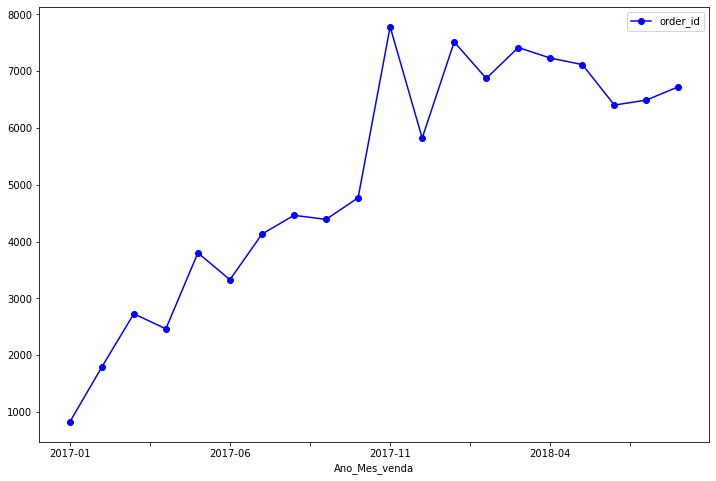

In [51]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
serie_pedidos_mes.set_index('Ano_Mes_venda').plot(ax=ax, marker='o', linestyle='-', color='blue')

In [52]:
serie_pedidos_mes.values

array([['2017-01', 824],
       ['2017-02', 1793],
       ['2017-03', 2731],
       ['2017-04', 2466],
       ['2017-05', 3803],
       ['2017-06', 3330],
       ['2017-07', 4134],
       ['2017-08', 4464],
       ['2017-09', 4392],
       ['2017-10', 4772],
       ['2017-11', 7782],
       ['2017-12', 5823],
       ['2018-01', 7516],
       ['2018-02', 6873],
       ['2018-03', 7417],
       ['2018-04', 7231],
       ['2018-05', 7117],
       ['2018-06', 6404],
       ['2018-07', 6492],
       ['2018-08', 6728]], dtype=object)

## Função para as metricas de erro

In [53]:
# Função que retorna a Metricas de erro do previsto com o atual

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'minmax':minmax})
    

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 5.1. MODELO ARIMA

<function matplotlib.pyplot.show>

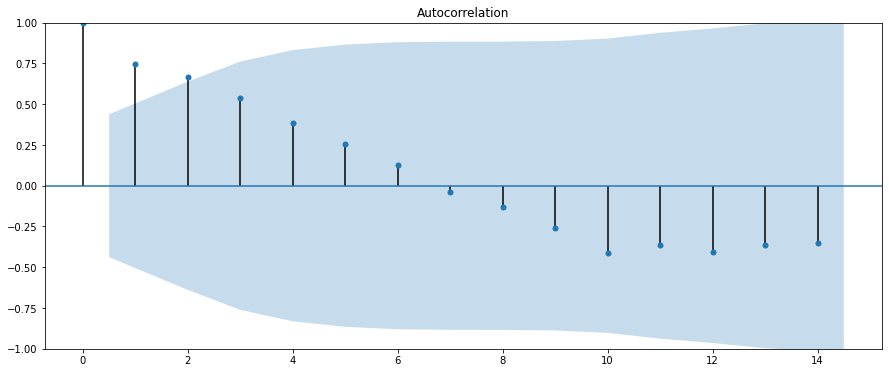

In [55]:
# *************************
# ARIMA 
# esse com status model não tem o ARIMA sazonal
# 1o.antes do modelo ARIMA, gerar o diagrama de autocorrelação ACF e autocorrelação parcial PACF
# arima1.reset_index(drop=True, inplace=True)

serie_pedidos_mes['Ano_Mes_venda'] = pd.to_datetime(serie_pedidos_mes['Ano_Mes_venda'], format="%Y-%m")
serie_pedidos_mes.set_index("Ano_Mes_venda",inplace=True)

plot_acf(serie_pedidos_mes)
plt.show

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



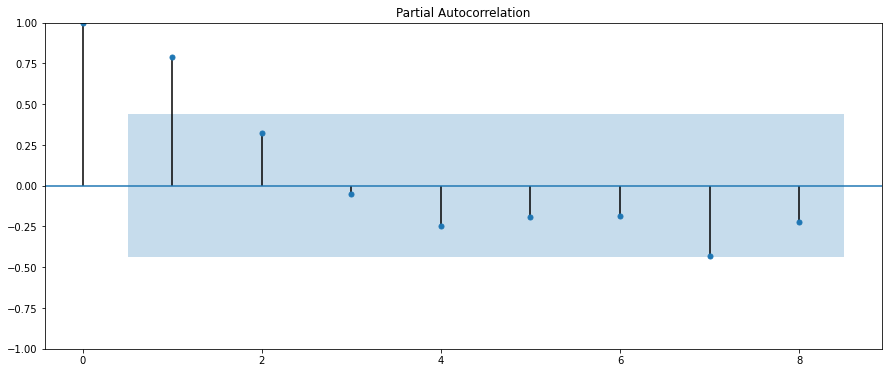

In [56]:
# auto correlação parcial

plot_pacf(serie_pedidos_mes,lags=8)
plt.show()

In [57]:
# Agora para o modelo Arima
# importa a biblioteca ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [58]:
# Criar o Modelo e depois o Fit , criar previsão
# não é por ordem sazonal
# modelo com melhor performance se apresentou com (2,1,0)

model_arima = ARIMA(serie_pedidos_mes, order=(2,1,0)) 
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               order_id   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -156.988
Date:                Fri, 15 Oct 2021   AIC                            319.976
Time:                        15:18:30   BIC                            322.810
Sample:                    01-01-2017   HQIC                           320.456
                         - 08-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3177      0.213     -1.492      0.136      -0.735       0.100
ar.L2          0.2417      0.443      0.545      0.585      -0.627       1.110
sigma2       8.09e+05   1.44e+05      5.623      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



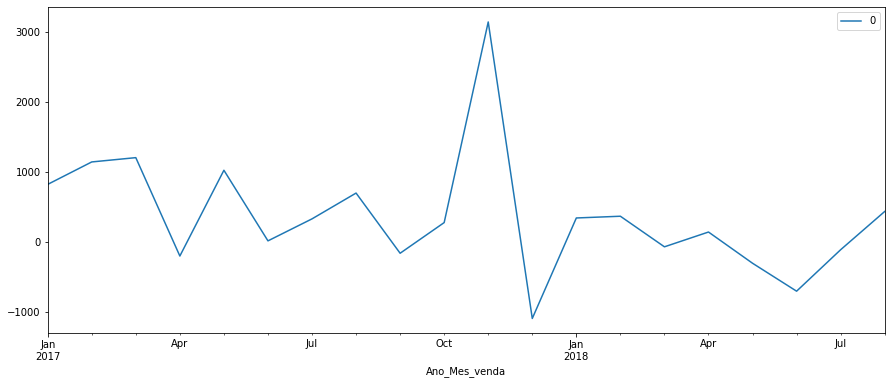

In [59]:
# transformar o modelo da parte residual
# o esperado é que flutue dentro da media zero

from pandas import DataFrame

residuo_arima = DataFrame(model_fit_arima.resid)
residuo_arima.plot()
plt.show()



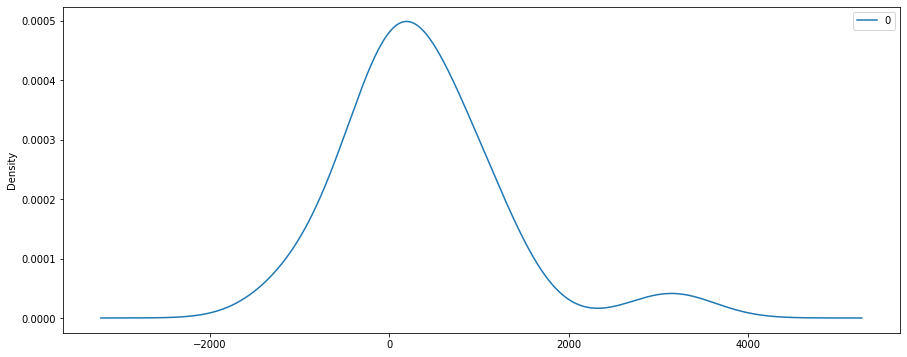

                 0
count    20.000000
mean    365.844656
std     880.896592
min   -1094.681147
25%    -123.572323
50%     304.015161
75%     730.776229
max    3148.109375


In [60]:
# outro gráfico com a densidade dos residuos
# tipo do gráfico é kde
# describe, gera algumas estatisticas do residuo

residuo_arima.plot(kind='kde')
plt.show()
print(residuo_arima.describe())



Previsot=7223.198641, esperado=7516.000000
Previsot=6346.131931, esperado=6873.000000
Previsot=7527.356343, esperado=7417.000000
Previsot=7077.886188, esperado=7231.000000
Previsot=7428.428567, esperado=7117.000000
Previsot=7107.904744, esperado=6404.000000
Previsot=6597.910191, esperado=6492.000000
Previsot=6279.671337, esperado=6728.000000


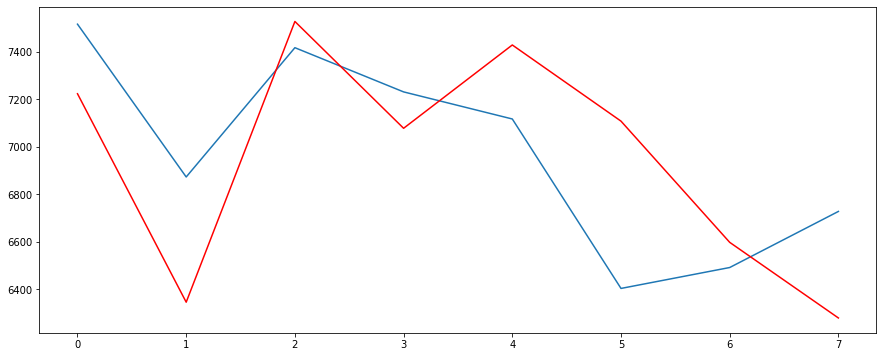

In [61]:
# avaliar a qualidade do modelo
X = serie_pedidos_mes.values

# 60% treino e 40% teste
size = int(len(X) * 0.60) 
train_arima, test_arima = X[0:size], X[size:len(X)]  # separando train e teste
history = [x for x in train_arima]
predictions_arima = list()

#percorrer os dados de teste fazendo a previsão usando o modelo
for t in range(len(test_arima)):
  model_arima = ARIMA(history, order=(2,1,0))  # la em cima onde apresentou o melhor resultado
#  model_fit = model.fit(disp=0) # ajustar o modelo, disp=0 para não exibir o processamento.   #  qdo executou com este, foi informado que alterou pra o de baixo
  model_fit_arima = model_arima.fit() # ajustar o modelo
  output = model_fit_arima.forecast() # faz a previsão
  yhat = output[0]  # vai imprimir textualmente e graficamente
  predictions_arima.append(yhat)
  obs = test_arima[t]
  history.append(obs)
  print('Previsot=%f, esperado=%f' % (yhat, obs))

# fazer a previsão e comparar com o observado/esperado/acontecido
# vai imprimir linha a linha do previsto (25% dos registros)
# e imprimir graficamente o observado e o previsto
plt.plot(test_arima)
plt.plot(predictions_arima, color='red')
plt.show()

# azul os dados abservados, acontecidos
# vermelho os dados que forão previstos apartir do modelo

In [62]:
# Metrica de erro

predictions_arima = np.array(predictions_arima)
predictions_arima  = predictions_arima.reshape(-1, 1)

result = forecast_accuracy(predictions_arima, test_arima)
print("MAE: ",result['mae'])
print("MAPE: ",result['mape'])
print("RMSE: ",result['rmse'])

MAE:  331.58896863002315
MAPE:  0.04853665365111183
RMSE:  387.8837067948556


## 5.2. MODELO AUTO ARIMA

In [63]:
# *****************
# AUTO ARIMA   
# O ARIMA pode ter muitas configurações diferentes e precisa interpretagar os diagrams de auto correlação / parcial, mas é um processo bem complicado não é intuitivo não tem muita logica
# então temos o AUTO ARIMA , que é uma especie de "força bruta" que vai testar todas as configurações dos parametros
# e tem a parte sazional

from pmdarima.arima import auto_arima




In [64]:
# start_p=1 : periodo de inicio
# trace= True: pra visualizar a saida
# stepwise=True: busca de uma forma inteligente o melhor modelo de forma mais rapida / False: de forma mais acentuada , demora mais
model_aarima = auto_arima(serie_pedidos_mes, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1,D=1, trace=True, error_action='ignore',
                              suppress_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=116.815, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=115.078, Time=0.40 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=117.082, Time=0.76 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=116.880, Time=0.42 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=117.011, Time=0.49 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=118.522, Time=0.54 sec
 AR

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,1)(0,1,0)[12] intercept   : AIC=12.000, Time=0.15 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,1)(1,1,0)[12] intercept   : AIC=14.000, Time=0.26 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,1)(0,1,1)[12] intercept   : AIC=14.000, Time=0.29 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,1)(1,1,1)[12] intercept   : AIC=16.000, Time=0.31 sec
 ARIMA(4,1,1)(0,1,0)[12] intercept   : AIC=267673056368.045, Time=0.31 sec
 ARIMA(3,1,2)(0,1,0)[12] intercept   : AIC=119.075, Time=0.48 sec
 ARIMA(2,1,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(4,1,0)(0,1,0)[12] intercept   : AIC=262119366627.893, Time=0.30 sec
 ARIMA(4,1,2)(0,1,0)[12] intercept   : AIC=118.139, Time=0.54 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(3,1,1)(0,1,0)[12] intercept
Total fit time: 16.381 seconds


In [65]:
print(model_aarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   20
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                   0.000
Date:                             Fri, 15 Oct 2021   AIC                             12.000
Time:                                     15:18:48   BIC                             11.675
Sample:                                          0   HQIC                             7.989
                                              - 20                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3906.0030         -0        inf      0.000   -3906.003   -3906.003
ar.L1              -0      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2968: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2968: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1337: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:675: RuntimeWarning:

invalid value encountered in true_divide



In [66]:
# com stepwise=True
# Best model:  ARIMA(3,1,1)(0,1,0)[12] intercept
# Total fit time: 13.698 seconds

# performace = 12
print(model_aarima.aic())

12.0


In [67]:
# separa o treino e teste
train_aarima = serie_pedidos_mes.loc['2017-01-01':'2017-12-01']
test_aarima = serie_pedidos_mes.loc['2018-01-01':]


In [68]:
model_aarima.fit(train_aarima)
# os parametros para o modelo

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

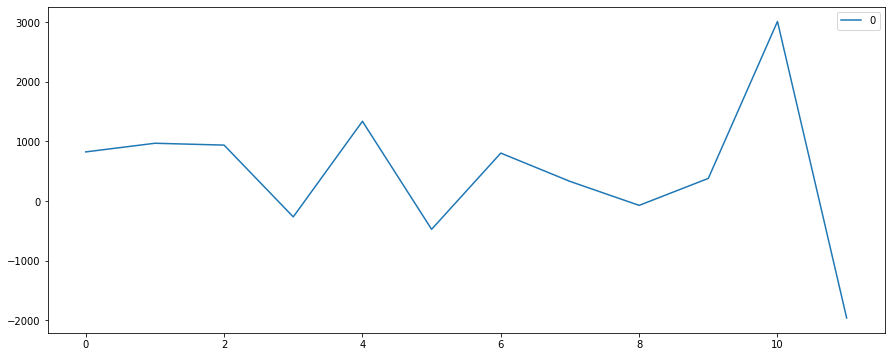

In [69]:
residuo_aarima = DataFrame(model_aarima.resid())
residuo_aarima.plot()
plt.show()


In [70]:
# agora fazer uma previsão para 8 meses
future_forecast_aarima = model_aarima.predict(n_periods=8)  


In [71]:
# transformar o future forecast para DataFrame
future_forecast_aarima = pd.DataFrame(future_forecast_aarima, index=test_aarima.index, columns=['order_id'])

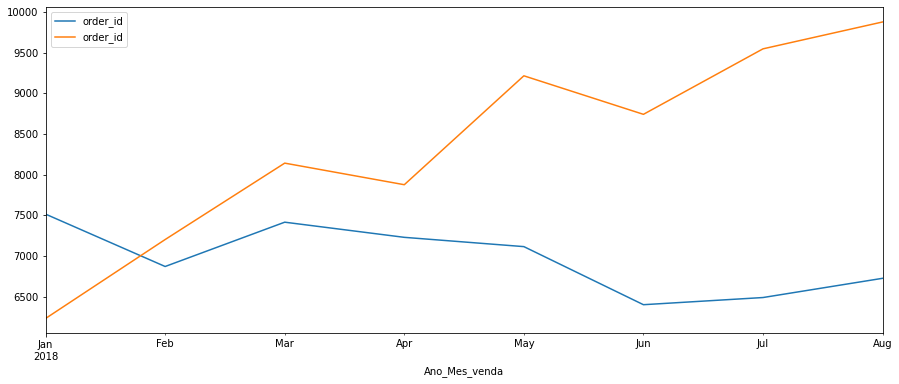

In [72]:
# plotar os dados, para comparar a previsao com os dados reais
# comparar a previsao com o ocorrido/ o que de fato aconteceu
pd.concat([test_aarima, future_forecast_aarima], axis=1).plot() 

In [73]:
# Metrica de erro AUTO ARIMA

future_forecast_aarima_value = future_forecast_aarima.values
test_aarima_value = test_aarima.values

result = forecast_accuracy(future_forecast_aarima_value, test_aarima_value)

print("MAE: ",result['mae'])
print("MAPE: ",result['mape'])
print("RMSE: ",result['rmse'])


MAE:  1702.1251544999227
MAPE:  0.2504093328719945
RMSE:  1993.0147877856446


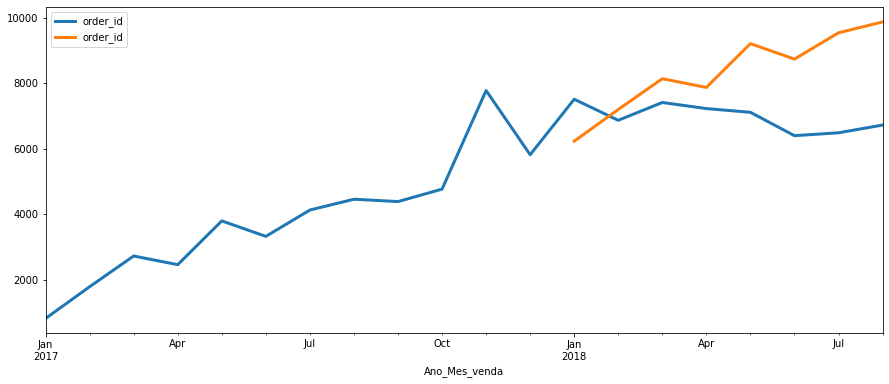

In [74]:
# comparar a previsão com a propria serie(dataset)
# a previsão(8 meses) segue uma tendencia de crescimento
pd.concat([serie_pedidos_mes, future_forecast_aarima], axis=1).plot(linewidth=3) 

## 5.3. MODELO SUAVIZAÇÃO EXPONENCIAL SIMPLES

In [75]:
# **********
# Suavização (alisamento) Exponencial SImples
# importar biblioteca
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [76]:
# 0,2 mais valor para as mais antigas
fit1 = SimpleExpSmoothing(serie_pedidos_mes).fit(smoothing_level=0.2, optimized=False)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [77]:
fit1.fittedvalues

Ano_Mes_venda
2017-01-01     824.000000
2017-02-01     824.000000
2017-03-01    1017.800000
2017-04-01    1360.440000
2017-05-01    1581.552000
2017-06-01    2025.841600
2017-07-01    2286.673280
2017-08-01    2656.138624
2017-09-01    3017.710899
2017-10-01    3292.568719
2017-11-01    3588.454975
2017-12-01    4427.163980
2018-01-01    4706.331184
2018-02-01    5268.264947
2018-03-01    5589.211958
2018-04-01    5954.769566
2018-05-01    6210.015653
2018-06-01    6391.412522
2018-07-01    6393.930018
2018-08-01    6413.544014
dtype: float64

In [78]:
fit1.params

{'damping_trend': nan,
 'initial_level': 824.0,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.2,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'use_boxcox': False}

In [79]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.2,False
initial_level,l.0,824.0,False


In [80]:
# medidas de qualidade de ajustes, qto menor melhor
fit1.aic, fit1.aicc, fit1.bic

(301.7400850507057, 304.4067517173724, 303.7315495978137)

In [81]:
# criou o modelo, agora vai fazer a previsão, o forecast
fcast1 = fit1.forecast(8).rename(r'$alpha=0.2$')
fcast1

2018-09-01    6476.435212
2018-10-01    6476.435212
2018-11-01    6476.435212
2018-12-01    6476.435212
2019-01-01    6476.435212
2019-02-01    6476.435212
2019-03-01    6476.435212
2019-04-01    6476.435212
Freq: MS, Name: $alpha=0.2$, dtype: float64

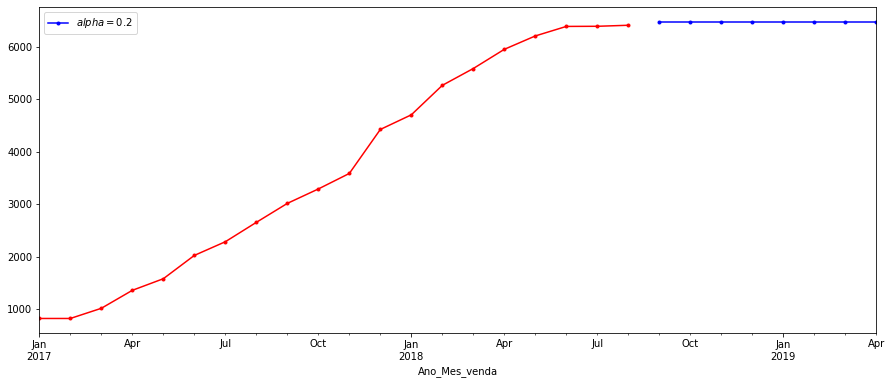

In [82]:
# plot da previsão
fcast1.plot(marker='.', color='blue', legend=True)
fit1.fittedvalues.plot(marker='.', color='red')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



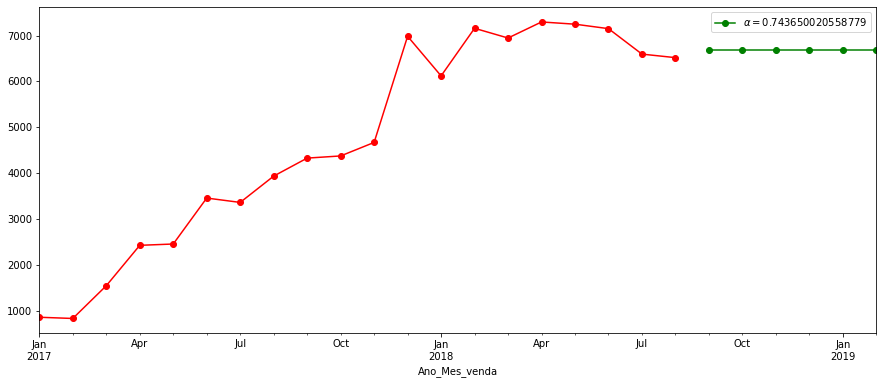

In [83]:
# abaixo o alpha optmizado, o proprio modelo encontra

fit3 = SimpleExpSmoothing(serie_pedidos_mes).fit()
fcast3 = fit3.forecast(6).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='red')

# agora encontrou o alpha = 0,74

In [84]:
# medidas de qualidade de ajustes, qto menor melhor
fit3.aic, fit3.aicc, fit3.bic


(279.39418753147055, 282.06085419813724, 281.3856520785785)

In [85]:
print(fit1.params['smoothing_level'])
print(fit3.params['smoothing_level'])



0.2
0.743650020558779


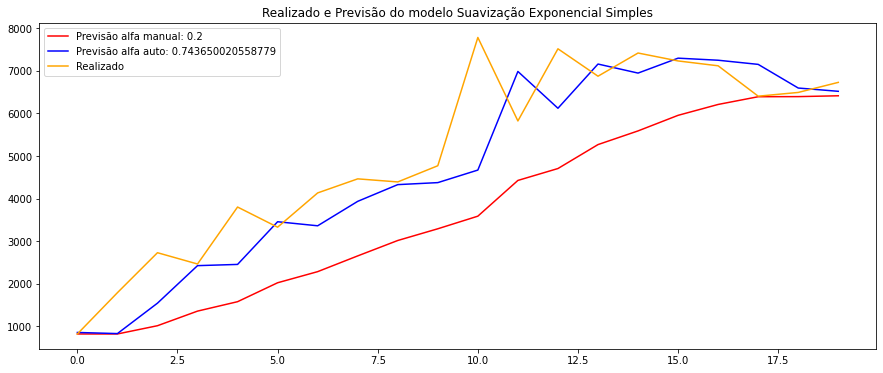

In [86]:
## Avaliação do modelo com com Alfa manual e automatico 

serie_value = serie_pedidos_mes['order_id'].values
plt.plot(fit1.fittedvalues.values, label='Previsão alfa manual: '+str(fit1.params['smoothing_level']), color='red')
plt.plot(fit3.fittedvalues.values, label='Previsão alfa auto: '+str(fit3.params['smoothing_level']), color='blue')
plt.plot(serie_value, label='Realizado', color='orange')
plt.legend(loc='upper left')
plt.title('Realizado e Previsão do modelo Suavização Exponencial Simples')
plt.show()



In [87]:
# Metrica de erro Suavização Exponencial Simples (Alpha=0.2)

result = forecast_accuracy(fit1.fittedvalues.values, serie_value)
print("MAE: ",result['mae'])
print("MAPE: ",result['mape'])
print("RMSE: ",result['rmse'])

MAE:  1413.1088028768586
MAPE:  0.3033347192985135
RMSE:  1708.723921648631


In [88]:
# Metrica de erro Suavização Exponencial Simples (Auto)

result = forecast_accuracy(fit3.fittedvalues.values, serie_value)
print("MAE: ",result['mae'])
print("MAPE: ",result['mape'])
print("RMSE: ",result['rmse'])

MAE:  656.545108438019
MAPE:  0.14516758503085037
RMSE:  977.3596375861428


## 5.4.MODELO LTSM

In [89]:
serie_pedidos_mes.head()

,order_id
Ano_Mes_venda,
2017-01-01,824
2017-02-01,1793
2017-03-01,2731
2017-04-01,2466
2017-05-01,3803


In [90]:
# gera dataset com o formato que o Keras espera , data raw para dados não tratados
data_raw = serie_pedidos_mes.values.astype('float32')     

scaler = MinMaxScaler(feature_range=(0,1))                # normalizar os dados entre 0 e 1 , outra necessidada para redes neurais
scaled_values = scaler.fit_transform(data_raw)            # transformação 

separando treino e teste, deixando 15 meses para Treino e 5 meses para testes

In [91]:
train_size = len(scaled_values)-5  
test_size = len(scaled_values) - train_size 

train, test = scaled_values[0:train_size,:], scaled_values[train_size:len(scaled_values),:]  

print(len(serie_pedidos_mes.values))
print(len(train)) 
print(len(test))  

20
15
5


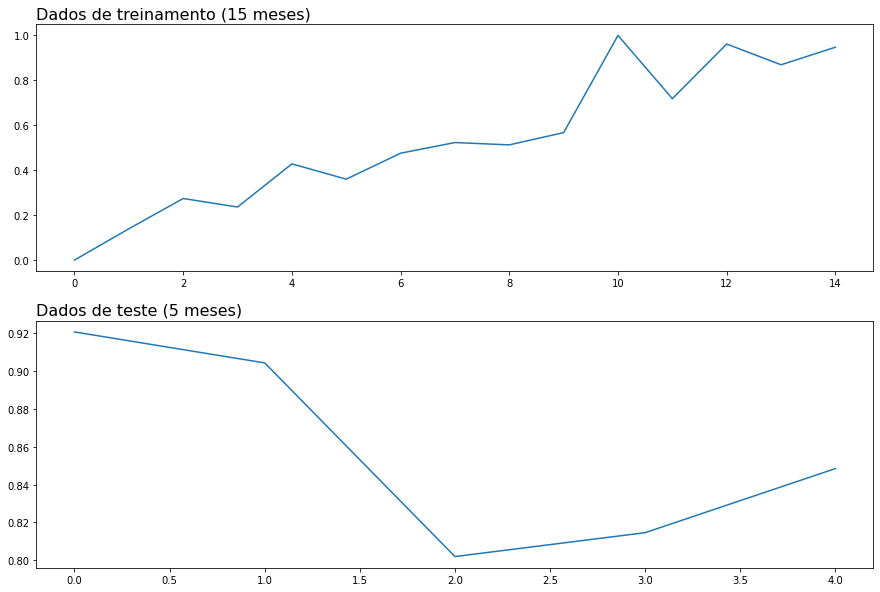

In [92]:
flg = plt.figure(figsize=(15,10))
ax = plt.subplot(211)
ax.set_title('Dados de treinamento (' +str(len(train))+' meses)', loc='left', fontsize=16)
plt.plot(train)

ax = plt.subplot(212)
ax.set_title('Dados de teste (' +str(len(test))+' meses)', loc='left', fontsize=16)
plt.plot(test)

In [93]:
# Criar dataset de X, Y com atraso
def create_dataset(dataset, window_size=1):
  dataX, dataY = [], []
  for i in range(len(dataset) - window_size):
      a = dataset[i:(i + window_size), 0]
      dataX.append(a)
      dataY.append(dataset[i + window_size, 0])
  return np.array(dataX), np.array(dataY)         # transforma o retorno num array



In [94]:
window_size = 1                                   # vai utilizar 1 mês para traz para prever o proximo valor

trainX, trainY = create_dataset(train, window_size)
testX, testY   = create_dataset(test, window_size)

print ("Fomato original dos dados de treino: ")
print (trainX.shape)     

Fomato original dos dados de treino: 
(14, 1)


In [95]:
print('dataset: ', list(train.reshape(1,-1)[0]))
print('datasetX: ', list(trainX.reshape(1,-1)[0]))  # valor passado tenta prever prox.valor. aqui é janela de 1 (ou 5)
print('datasetY: ', list(trainY))                   # é o valor que se que prever, é o proximo dia
trainY[0:]

dataset:  [0.0, 0.13926417, 0.274073, 0.23598737, 0.42814028, 0.36016098, 0.4757114, 0.5231388, 0.51279104, 0.56740445, 0.99999994, 0.7184536, 0.9617706, 0.869359, 0.94754237]
datasetX:  [0.0, 0.13926417, 0.274073, 0.23598737, 0.42814028, 0.36016098, 0.4757114, 0.5231388, 0.51279104, 0.56740445, 0.99999994, 0.7184536, 0.9617706, 0.869359]
datasetY:  [0.13926417, 0.274073, 0.23598737, 0.42814028, 0.36016098, 0.4757114, 0.5231388, 0.51279104, 0.56740445, 0.99999994, 0.7184536, 0.9617706, 0.869359, 0.94754237]


array([0.13926417, 0.274073  , 0.23598737, 0.42814028, 0.36016098,
       0.4757114 , 0.5231388 , 0.51279104, 0.56740445, 0.99999994,
       0.7184536 , 0.9617706 , 0.869359  , 0.94754237], dtype=float32)

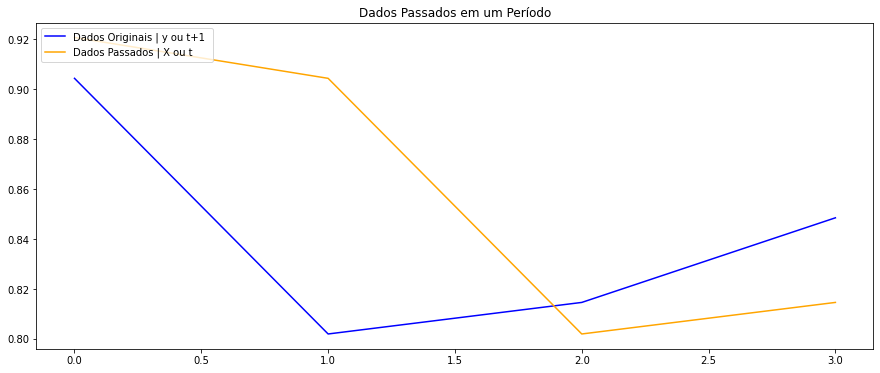

In [96]:
plt.plot(testY, label='Dados Originais | y ou t+1 ', color='blue')
plt.plot(testX, label='Dados Passados | X ou t ', color='orange')
plt.legend(loc='upper left')
plt.title('Dados Passados em um Período')
plt.show()

In [97]:
# Treino e teste no formato esperado pelo Keras
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print ("Fomato Keras dos dados de treino: ")
print (trainX.shape)     # entradas de 5 dias

Fomato Keras dos dados de treino: 
(14, 1, 1)


In [98]:
# inicializar o modelo
model = Sequential()   

# adicionando as camadas de redes neurais
# criando 100 neuronios na camada oculta / return_sequences = True faz com que a camada da rede retorne todos histórico, incluindo as saidas, todas as vezes
model.add(LSTM(units = 100, input_shape=(trainX.shape[1], trainX.shape[2]))) 
model.add(Dropout(0.1))                   # 10% of dropout, coloca um pouco de ruido, para aprender a ser um pouco mais generico, evitar overfitting
model.add(Dense(1))                       # prever a saida de um valor

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])  # parametros para optimizar

# units = 100 : com 100 de recorrencia tem 40800 parametros treinaveis
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [99]:
# treinamento
# 5 meses e 1 mes

history =  model.fit(trainX, trainY, 
                     epochs = 100, batch_size = 5,
                     validation_data=(testX, testY),
                     shuffle=False)

score = model.evaluate(testX, testY, verbose=0)

#Print scores
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Epoch 1/100
3/3 [==============================] - 3s 366ms/step - loss: 0.3784 - accuracy: 0.0000e+00 - val_loss: 0.6508 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.3594 - accuracy: 0.0000e+00 - val_loss: 0.6168 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.3371 - accuracy: 0.0000e+00 - val_loss: 0.5836 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 0.3209 - accuracy: 0.0000e+00 - val_loss: 0.5510 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.3001 - accuracy: 0.0000e+00 - val_loss: 0.5191 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2829 - accuracy: 0.0000e+00 - val_loss: 0.4880 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2719 - accuracy: 0.0000e+00 - val_los

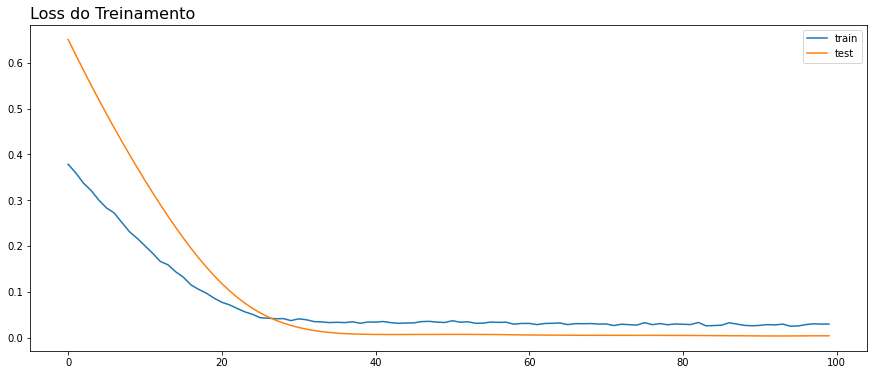

In [100]:
# É plotado um gráfico da perda em função do número de épocas.
# O valor de perda (loss) implica o quão bem ou mal um determinado modelo se comporta após cada iteração de otimização. 
# Idealmente, seria de se esperar a redução da perda após cada, ou várias, iterações.

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss do Treinamento', loc='left', fontsize=16)
plt.legend()

In [101]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)  

# os dados estão normalizados, volta para o normal, invert predição
trainPredict = scaler.inverse_transform(trainPredict)
rtrainY      = scaler.inverse_transform([trainY])
testPredict  = scaler.inverse_transform(testPredict)
rtestY       = scaler.inverse_transform([testY])


In [102]:
#calcula o RMSE dos dados de treinamento e teste para verifiar o quanto erra conforme os parametros informado
# fazer validação do modelo

trainScore = math.sqrt(mean_squared_error(rtrainY[0], trainPredict[:,0]))
print('Train Socre: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(rtestY[0], testPredict[:,0]))
print('Test Socre: %.2f RMSE' % (testScore))

Train Socre: 1146.78 RMSE
Test Socre: 426.97 RMSE


In [103]:
# Predição base de treinamento
predictDates  = serie_pedidos_mes.head(len(trainX)).index
actual_chart  = go.Scatter(x=predictDates, y=rtrainY[0], name= 'Actual Real Pedidos')
predict_chart = go.Scatter(x=predictDates, y=trainPredict[:, 0], name= 'Predict Pedidos')
py.iplot([predict_chart, actual_chart])

In [104]:
# Predição base de teste
predictDates = serie_pedidos_mes.tail(len(testX)).index
actual_chart  = go.Scatter(x=predictDates, y=rtestY[0], name= 'Actual Pedidos')
predict_chart = go.Scatter(x=predictDates, y=testPredict[:,0], name = 'Predict Pedidos')
py.iplot([predict_chart, actual_chart]) 

In [105]:
# Metrica de erro LTSE

rtestY2  = rtestY.reshape(-1, 1)

result = forecast_accuracy(testPredict, rtestY2)
print("MAE: ",result['mae'])
print("MAPE: ",result['mape'])
print("RMSE: ",result['rmse'])

MAE:  395.9817698581462
MAPE:  0.058624452443475694
RMSE:  426.97488782567274
